In [42]:
import pandas as pd


data = pd.read_excel("GAIA IA v.1.2.xlsx")
data = data.drop(data.columns[0], axis=1)
mapping = {0: 'Al2O3', 1: 'Fe2O3', 2: '>63mm', 3: '>45mm', 4:'CS-C', 5: 'RMS', 6: 'A.A.', 7: 'Carbono', 8: 'L', 9: 'a', 10: '%'}
for i in range(11):
    data.rename(columns={data.columns[i]: mapping[i]+'.0'}, inplace=True)

In [43]:
actual_zeros = set()
total_zeros = 0
for i in range(len(data)):
    for j in range(len(mapping)-1):
        for k in range(7):
            if data.iloc[i, j+11*k] == 0 and data.iloc[i, 10+ 11*k] != 0:
                actual_zeros.add((i, j+11*k))

for col in data.columns:
    if col not in actual_zeros:
        data[col] = data[col].replace(0, 1e-10)
for i, j in actual_zeros:
    data.iloc[i, j] = 0

In [44]:
corr_matrix = data.corr()
target_columns = [
    "Al2O3.7",
    "Fe2O3.7",
    "CS-C.7",
    "Carbono.7",
]

datasets = {}
def get_correlated_features(target_columns, threshold, datasets):
    for target in target_columns:
        correlated_features = corr_matrix[target][abs(corr_matrix[target]) > threshold].index.tolist()
        datasets[target] = data[correlated_features].drop(columns=[target])
        print(f"Correlated features for {target}: {correlated_features}")

get_correlated_features(target_columns, 0.1, datasets)

Correlated features for Al2O3.7: ['Al2O3.0', 'Fe2O3.0', 'L.0', 'a.0', '%.0', 'Al2O3.1', 'Fe2O3.1', '>63mm.1', 'A.A..1', 'L.1', 'a.1', '%.1', 'Al2O3.2', 'Fe2O3.2', '>63mm.2', 'CS-C.2', 'Carbono.2', 'L.2', 'Al2O3.3', 'Fe2O3.3', '>63mm.3', '>45mm.3', 'CS-C.3', 'RMS.3', 'A.A..3', 'Carbono.3', 'L.3', 'a.3', 'Al2O3.4', 'Fe2O3.4', '>63mm.4', '>45mm.4', 'CS-C.4', 'RMS.4', 'A.A..4', 'Carbono.4', 'L.4', 'a.4', '%.4', 'Al2O3.5', 'Fe2O3.5', '>63mm.5', '>45mm.5', 'CS-C.5', 'RMS.5', 'A.A..5', 'Carbono.5', 'L.5', 'a.5', '%.5', 'Al2O3.6', 'Fe2O3.6', '>63mm.6', '>45mm.6', 'CS-C.6', 'RMS.6', 'A.A..6', 'Carbono.6', 'L.6', 'a.6', '%.6', 'Al2O3.7', 'CS-C.7']
Correlated features for Fe2O3.7: ['Fe2O3.0', 'L.0', 'a.0', 'Al2O3.1', 'Fe2O3.1', '>63mm.1', '>45mm.1', 'CS-C.1', 'RMS.1', 'A.A..1', 'L.1', 'a.1', '%.1', 'L.2', 'a.2', 'Fe2O3.4', 'RMS.4', 'A.A..4', 'a.4', '%.4', 'A.A..5', 'a.5', 'Fe2O3.7', 'CS-C.7', 'Carbono.7']
Correlated features for CS-C.7: ['Al2O3.0', 'Carbono.0', '%.0', 'Al2O3.1', '>45mm.2', 'A.A..

In [45]:
X = {}
y = {}
for target in target_columns:
    X[target] = datasets[target]
    y[target] = data[target]
    print(f"X[{target}]: {X[target].shape}, y[{target}]: {y[target].shape}")
    

X[Al2O3.7]: (230, 62), y[Al2O3.7]: (230,)
X[Fe2O3.7]: (230, 24), y[Fe2O3.7]: (230,)
X[CS-C.7]: (230, 53), y[CS-C.7]: (230,)
X[Carbono.7]: (230, 25), y[Carbono.7]: (230,)


In [46]:
# #Apply linear regression
# from sklearn.linear_model import LinearRegression
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import mean_squared_error, r2_score


# for target in target_columns:
#     X_train, X_test, y_train, y_test = train_test_split(X[target], y[target], test_size=0.2, random_state=42)
#     model = LinearRegression()
#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_test)

#     mse = mean_squared_error(y_test, y_pred)
#     r2 = r2_score(y_test, y_pred)

#     print(f"\n {target}")
#     print(f"   MSE: {mse:.4f}")
#     print(f"   R² Score: {r2:.4f}")

In [47]:
import matplotlib.pyplot as plt
def plot_pred(y_data, y_pred):
    y_actual_sorted = y_data.reset_index(drop=True)
    y_pred_sorted = pd.Series(y_pred).reset_index(drop=True)
    plt.figure(figsize=(10, 4))
    plt.plot(y_actual_sorted, label='Actual', linewidth=2)
    plt.plot(y_pred_sorted, label='Predicted', linewidth=2, linestyle='--')
    plt.title(f'Actual vs Predicted Values for {y_data.name}')
    plt.xlabel('Sample Index')
    plt.ylabel(f'{y_data.name}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


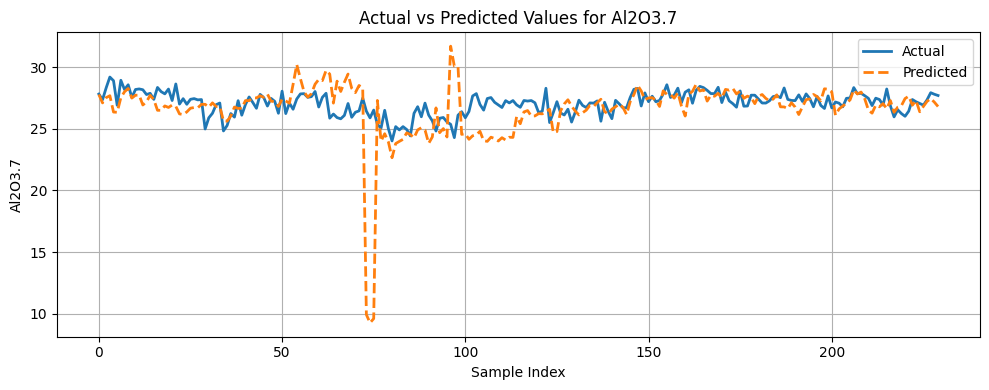


Al2O3.7
   MSE (CV): 5.5277
   R² Score (CV): -5.5434
   MAE (CV): 1.1912


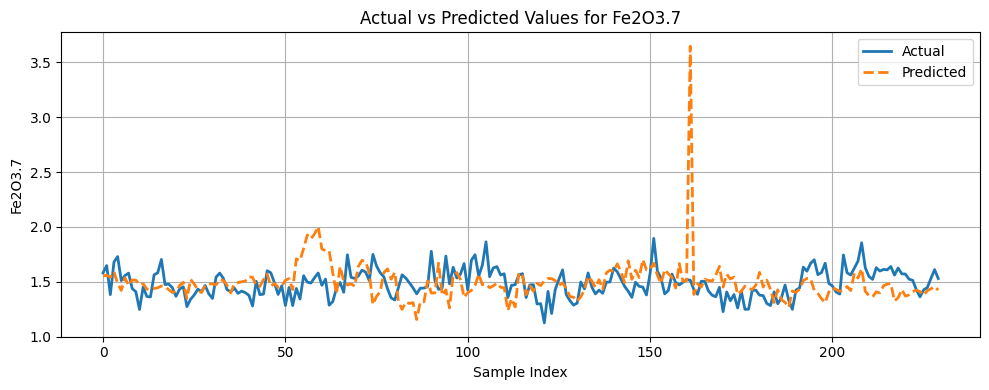


Fe2O3.7
   MSE (CV): 0.0476
   R² Score (CV): -2.0038
   MAE (CV): 0.1411


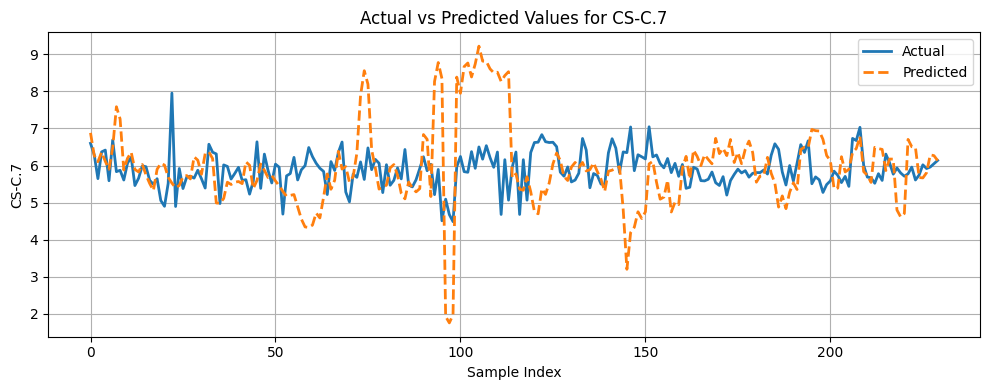


CS-C.7
   MSE (CV): 1.3667
   R² Score (CV): -4.8370
   MAE (CV): 0.8371


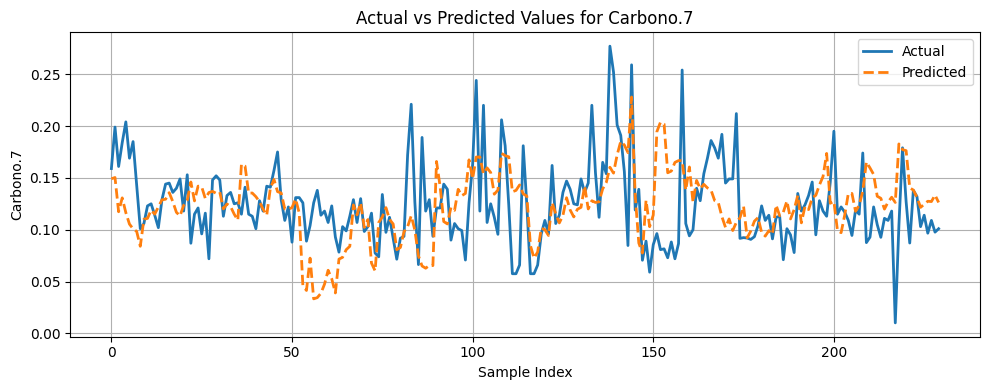


Carbono.7
   MSE (CV): 0.0019
   R² Score (CV): -0.2268
   MAE (CV): 0.0330

Average MSE across all targets: 1.7360
Average R² Score across all targets: -3.1528
Average MAE across all targets: 0.5506


In [48]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt

for target in target_columns:
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', LinearRegression())
    ])

    X_data = X[target]    
    y_data = y[target]
      
    y_pred = cross_val_predict(pipeline, X_data, y_data, cv=5)

    plot_pred(y_data, y_pred)

    mse = mean_squared_error(y_data, y_pred)
    r2 = r2_score(y_data, y_pred)
    mae = mean_absolute_error(y_data, y_pred)

    print(f"\n{target}")
    print(f"   MSE (CV): {mse:.4f}")
    print(f"   R² Score (CV): {r2:.4f}")
    print(f"   MAE (CV): {mae:.4f}")
    

# calculate average R² and MSE across all targets
avg_mse = sum(mean_squared_error(y[target], cross_val_predict(pipeline, X[target], y[target], cv=5)) for target in target_columns) / len(target_columns)
avg_r2 = sum(r2_score(y[target], cross_val_predict(pipeline, X[target], y[target], cv=5)) for target in target_columns) / len(target_columns)
avg_mae = sum(mean_absolute_error(y[target], cross_val_predict(pipeline, X[target], y[target], cv=5)) for target in target_columns) / len(target_columns)
print(f"\nAverage MSE across all targets: {avg_mse:.4f}")
print(f"Average R² Score across all targets: {avg_r2:.4f}")
print(f"Average MAE across all targets: {avg_mae:.4f}")



In [49]:
datasets = {}
get_correlated_features(target_columns, 0.2, datasets)
X = {}
y = {}
for target in target_columns:
    X[target] = datasets[target]
    y[target] = data[target]
    print(f"X[{target}]: {X[target].shape}, y[{target}]: {y[target].shape}")

Correlated features for Al2O3.7: ['Al2O3.0', '%.0', 'Al2O3.1', 'A.A..1', 'a.1', '%.1', 'Al2O3.2', 'Fe2O3.2', '>63mm.2', 'CS-C.2', 'L.2', 'CS-C.3', 'RMS.3', 'A.A..3', 'L.3', 'Al2O3.4', 'Fe2O3.4', '>63mm.4', '>45mm.4', 'CS-C.4', 'RMS.4', 'A.A..4', 'Carbono.4', 'L.4', 'a.4', '%.4', 'Al2O3.5', 'Fe2O3.5', '>63mm.5', '>45mm.5', 'RMS.5', 'Carbono.5', 'L.5', '%.5', 'Al2O3.6', 'Fe2O3.6', 'CS-C.6', 'RMS.6', 'A.A..6', 'L.6', '%.6', 'Al2O3.7']
Correlated features for Fe2O3.7: ['>63mm.1', 'RMS.1', 'A.A..1', 'L.1', 'Fe2O3.7', 'CS-C.7']
Correlated features for CS-C.7: ['A.A..3', 'Fe2O3.7', 'CS-C.7']
Correlated features for Carbono.7: ['Carbono.7']
X[Al2O3.7]: (230, 41), y[Al2O3.7]: (230,)
X[Fe2O3.7]: (230, 5), y[Fe2O3.7]: (230,)
X[CS-C.7]: (230, 2), y[CS-C.7]: (230,)
X[Carbono.7]: (230, 0), y[Carbono.7]: (230,)


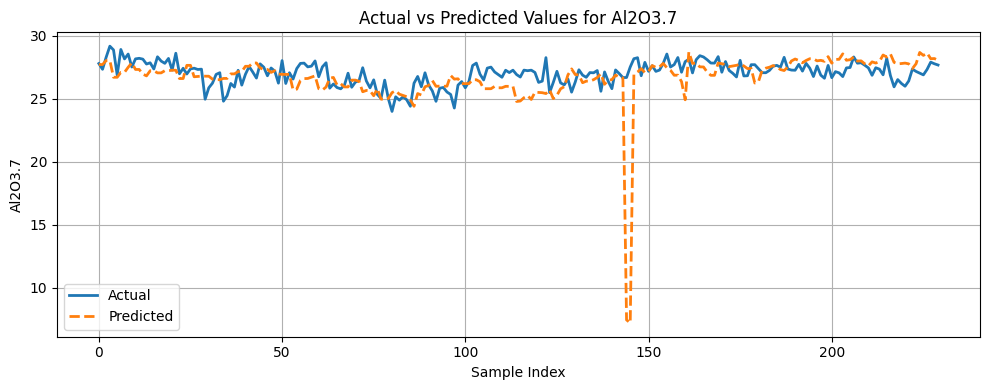


Al2O3.7
   MSE (CV): 4.4093
   R² Score (CV): -4.2196


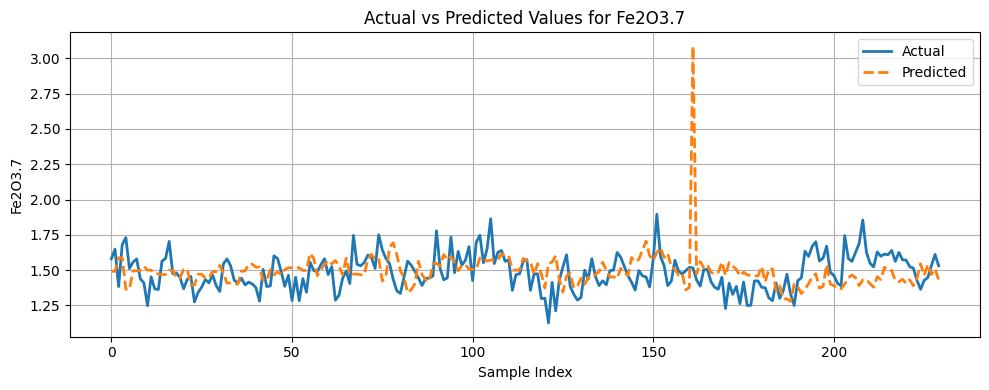


Fe2O3.7
   MSE (CV): 0.0309
   R² Score (CV): -0.9535


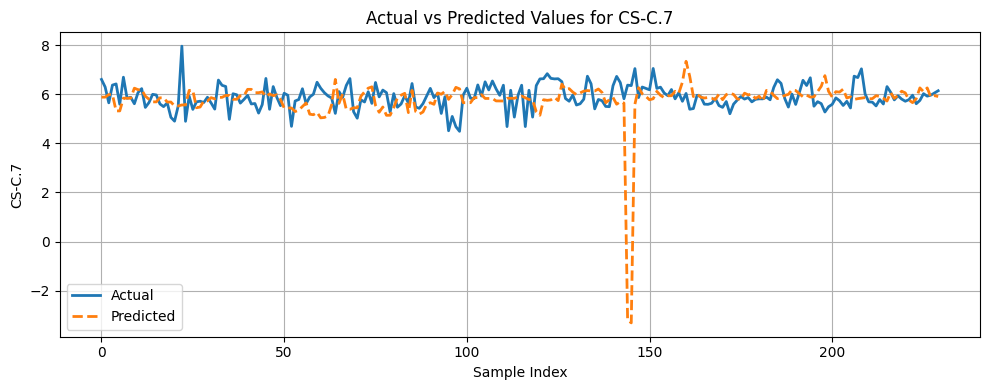


CS-C.7
   MSE (CV): 1.1679
   R² Score (CV): -3.9878


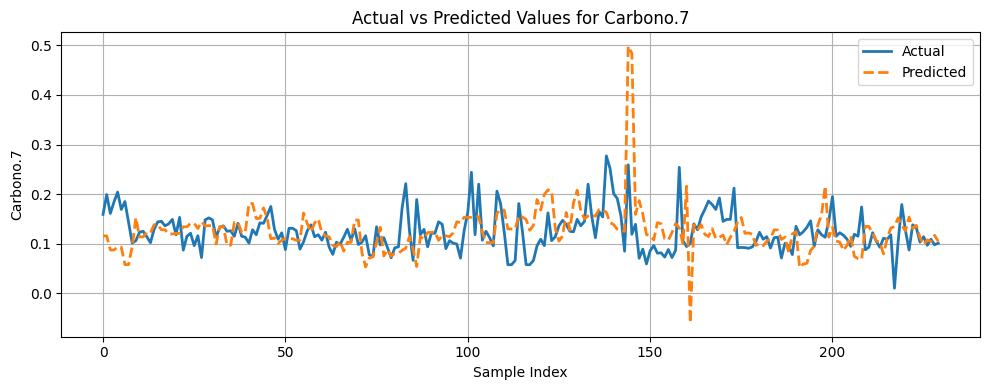


Carbono.7
   MSE (CV): 0.0032
   R² Score (CV): -1.0316


In [50]:
y_targets = ['Al2O3.7', 'Fe2O3.7', 'CS-C.7', 'Carbono.7']
X = data.iloc[:, :33]
y = data[y_targets]

for target in y_targets:
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', LinearRegression())
    ])
    X_data = X
    y_data = y[target]
    
    y_pred = cross_val_predict(pipeline, X_data, y_data, cv=5)
    
    plot_pred(y_data, y_pred)
    
    mse = mean_squared_error(y_data, y_pred)
    r2 = r2_score(y_data, y_pred)
    
    print(f"\n{target}")
    print(f"   MSE (CV): {mse:.4f}")
    print(f"   R² Score (CV): {r2:.4f}")

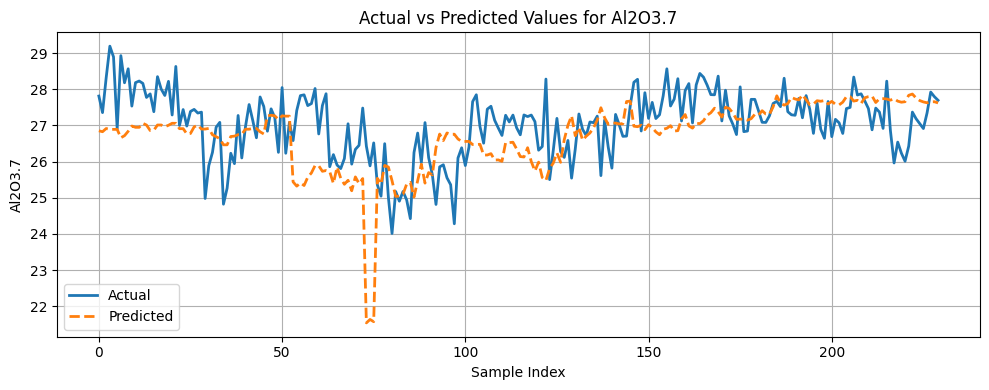


Al2O3.7
   MSE (CV): 1.1989
   R² Score (CV): -0.4193


In [51]:
#Using only AL203 to predict Al2O3.7
X = data[['Al2O3.0', 'Al2O3.1', 'Al2O3.2', 'Al2O3.3', 'Al2O3.4', 'Al2O3.5', 'Al2O3.6']]
y = data['Al2O3.7']
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LinearRegression())
])
X_data = X
y_data = y

y_pred = cross_val_predict(pipeline, X_data, y_data, cv=5)

plot_pred(y_data, y_pred)

mse = mean_squared_error(y_data, y_pred)
r2 = r2_score(y_data, y_pred)
print(f"\nAl2O3.7")
print(f"   MSE (CV): {mse:.4f}")
print(f"   R² Score (CV): {r2:.4f}")


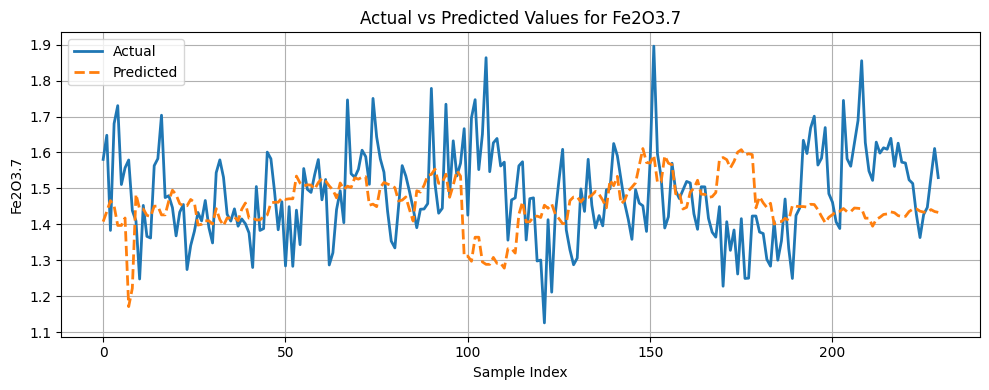


Fe2O3.7
   MSE (CV): 0.0244
   R² Score (CV): -0.5426


In [52]:
#Predicting Fe2O3.7
X = data[['Fe2O3.0', 'Fe2O3.1', 'Fe2O3.2', 'Fe2O3.3', 'Fe2O3.4', 'Fe2O3.5', 'Fe2O3.6']]
y = data['Fe2O3.7']
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LinearRegression())
])
X_data = X
y_data = y
y_pred = cross_val_predict(pipeline, X_data, y_data, cv=5)
plot_pred(y_data, y_pred)
mse = mean_squared_error(y_data, y_pred)
r2 = r2_score(y_data, y_pred)
print(f"\nFe2O3.7")
print(f"   MSE (CV): {mse:.4f}")
print(f"   R² Score (CV): {r2:.4f}")


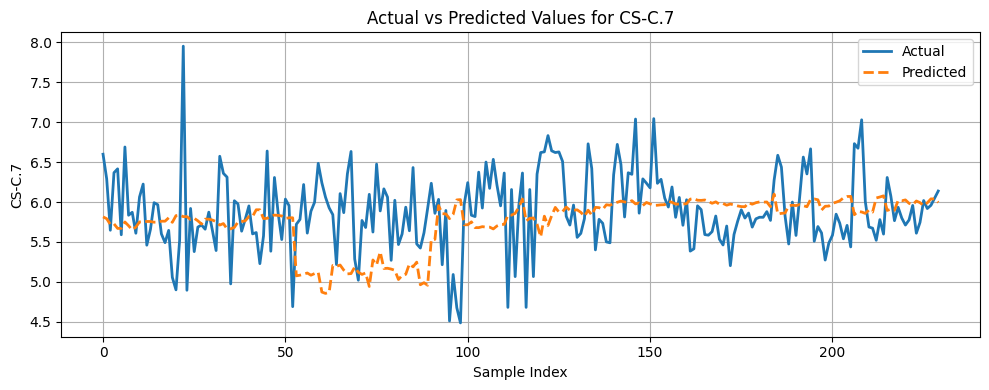


CS-C.7
   MSE (CV): 0.3517
   R² Score (CV): -0.5021


In [53]:
#Predicting CS-C.7
X = data[['CS-C.0', 'CS-C.1', 'CS-C.2', 'CS-C.3', 'CS-C.4', 'CS-C.5', 'CS-C.6']]
y = data['CS-C.7']
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LinearRegression())
])
X_data = X
y_data = y
y_pred = cross_val_predict(pipeline, X_data, y_data, cv=5)  
plot_pred(y_data, y_pred)
mse = mean_squared_error(y_data, y_pred)
r2 = r2_score(y_data, y_pred)
print(f"\nCS-C.7")
print(f"   MSE (CV): {mse:.4f}")
print(f"   R² Score (CV): {r2:.4f}")


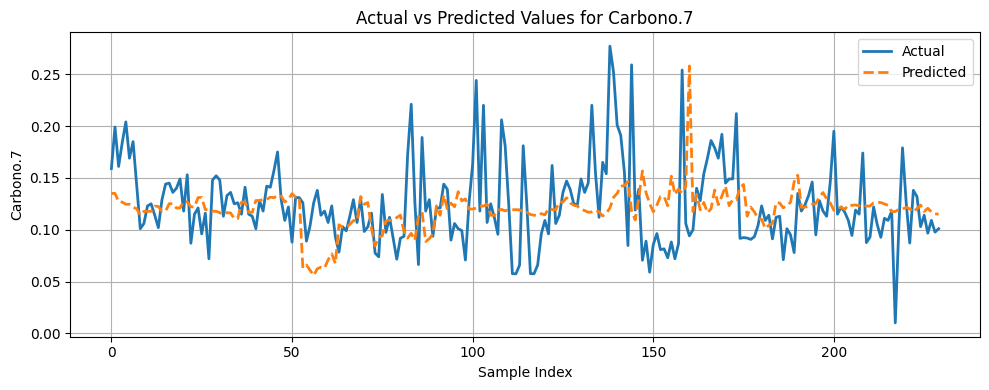


Carbono.7
   MSE (CV): 0.0018
   R² Score (CV): -0.1723


In [54]:
#Predicting Carbono.7
X = data[['Carbono.0', 'Carbono.1', 'Carbono.2', 'Carbono.3', 'Carbono.4', 'Carbono.5', 'Carbono.6']]
y = data['Carbono.7']
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LinearRegression())
])
X_data = X
y_data = y
y_pred = cross_val_predict(pipeline, X_data, y_data, cv=5)
plot_pred(y_data, y_pred)
mse = mean_squared_error(y_data, y_pred)
r2 = r2_score(y_data, y_pred)
print(f"\nCarbono.7")
print(f"   MSE (CV): {mse:.4f}")
print(f"   R² Score (CV): {r2:.4f}")
